# Importing the required python libraries



In [1]:

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt 
import seaborn as sb # used to plot the heatmap

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error,  mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)
start = time.time()

# Creating a python class for loading the data into Neural network

In [2]:
class TabularDataset(Dataset):
    def __init__(self, data, cat_cols=None, output_col=None):
        """
        Characterizes a Dataset for PyTorch

        Parameters
        ----------

        data: pandas data frame
        The data frame object for the input data. It must
        contain all the continuous, categorical and the
        output columns to be used.

        cat_cols: List of strings
        The names of the categorical columns in the data.
        These columns will be passed through the embedding
        layers in the model. These columns must be
        label encoded beforehand. 

        output_col: string
        The name of the output variable column in the data
        provided.
        """

        self.n = data.shape[0] # n stores the total number of data points

        if output_col:
            self.y = data[output_col].astype(np.float32).values.reshape(-1, 1) #data[output_col] contains two columns 
                                                                            #(first column is the index). This line converts it 
                                                                            # to single column
            
        else:
            self.y = np.zeros((self.n, 1)) # a general case when out

        self.cat_cols = cat_cols if cat_cols else [] # categorical inputs are stored in "self.cat_cols"
        self.cont_cols = [
            col for col in data.columns if col not in self.cat_cols + [output_col] # finds out the columns that have 
                                                                                   # contionuos inputs
        ]

        if self.cont_cols:
            self.cont_X = data[self.cont_cols].astype(np.float32).values # The data corresponding to 
                                                                         # continuous columns are stored in "self.cont_x"
        else:
            self.cont_X = np.zeros((self.n, 1))

        if self.cat_cols:
            self.cat_X = data[cat_cols].astype(np.int64).values # The data corresponding to 
                                                                # categorical columns are stored in "self.cont_x"
        else:
            self.cat_X = np.zeros((self.n, 1))

    def __len__(self):
        """
        Denotes the total number of samples.
        """
        return self.n

    def __getitem__(self, idx):
        """
        Generates one sample of data as a triplet --> #(output, continous inputs, categorical inputs)
        """
        return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

# Definition of the Neural network

In [3]:
class FeedForwardNN(nn.Module):
    def __init__(
        self,
        emb_dims,
        no_of_cont,
        lin_layer_sizes,
        output_size,
        emb_dropout,
        lin_layer_dropouts,
    ):

        """
        Parameters
        ----------

        emb_dims: List of two element tuples
        This list will contain a two element tuple for each
        categorical feature. The first element of a tuple will
        denote the number of unique values of the categorical
        feature. The second element will denote the embedding
        dimension to be used for that feature.

        no_of_cont: Integer
        The number of continuous features in the data.

        lin_layer_sizes: List of integers.
        The size of each linear layer. The length will be equal
        to the total number
        of linear layers in the network.

        output_size: Integer
        The size of the final output.

        emb_dropout: Float
        The dropout to be used after the embedding layers.

        lin_layer_dropouts: List of floats
        The dropouts to be used after each linear layer.
        """

        super().__init__()

        # Embedding layers of categorical inputs
        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])

        no_of_embs = sum([y for x, y in emb_dims])
        self.no_of_embs = no_of_embs
        self.no_of_cont = no_of_cont

        # Linear Layers of the nueral network
        first_lin_layer = nn.Linear(
            self.no_of_embs + self.no_of_cont, lin_layer_sizes[0]
        ) # first layer where data is fed into the network
        # Following lines define the hidden layers
        self.lin_layers = nn.ModuleList(
            [first_lin_layer]
            + [
                nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                for i in range(len(lin_layer_sizes) - 1)
            ]
        )
        # Initializing the weights of neural network layers
        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        # Output Layer
        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm Layers, It is used to normalize the data into the layers to avoid overfitting and to optimize network
        self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
        self.bn_layers = nn.ModuleList(
            [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )

        # Dropout Layers used as regularization
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.droput_layers = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )

    def forward(self, cont_data, cat_data):
        # This function defines the mathematical operations of the neural network 
        if self.no_of_embs != 0: # Defines the embedding layer of categorical inputs
            x = [
                emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)
            ]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x) # dropout regularization of categorical inputs 

        if self.no_of_cont != 0:
            normalized_cont_data = self.first_bn_layer(cont_data) # defines the linear (normal nueral net hidden layer)
                                                                  # for continous inputs

            if self.no_of_embs != 0:
                x = torch.cat([x, normalized_cont_data], 1)
            else:
                x = normalized_cont_data
        # Batch normalization operation is done in this for loop
        for lin_layer, dropout_layer, bn_layer in zip( 
            self.lin_layers, self.droput_layers, self.bn_layers
        ):

            x = F.relu(lin_layer(x))
#             x = F.sigmoid(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)

        return x # Returns the output of the network

# Data loading and preprocessing

In [4]:
# The data is read as a pandas data frame
data = pd.read_csv("finalized_data.csv").dropna()

In [5]:
data.columns


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], dtype='object')

### One-hot encoding of categorical features

In [6]:
# Array that specifies which columns are categorical inputs
categorical_features = ["0", "1", "2", "3", "4","5", "6", "7", "8"] # Except column "7", all are label encoded and "7" is 
                                                               # one-hot encoded. 
# Array that specifies which columns are continuous inputs
contnuous_features = ["9","10","11"]
output_feature = "12"  # specifies which column is output


temp={}
label_encoders = {} 
# for loop starts for label encoding
for i in range(0,len(categorical_features)):
    #codes for one-hot encoding
    label_encoders[categorical_features[i]] = OneHotEncoder(handle_unknown='ignore')
    label_encoders[categorical_features[i]].fit(data[categorical_features[i]].values.reshape(-1,1))
    temp[categorical_features[i]]=label_encoders[categorical_features[i]].transform(data[categorical_features[i]].values.reshape(-1,1)).toarray() 
    

In [7]:
#printing the dimensions of each categorical variables after one-hot encoding
for i in range(0,len(temp)):
    print(temp[categorical_features[i]].shape)

(1263600, 13)
(1263600, 3)
(1263600, 3)
(1263600, 3)
(1263600, 3)
(1263600, 4)
(1263600, 3)
(1263600, 4)
(1263600, 21)


In [8]:
# Adding the one hot encoded features into the data
# The new columns will be named from 13 onwards.
ind=13
new_categorical_features=[]
for i in range(0,len(categorical_features)):
    for j in range(0,temp[categorical_features[i]].shape[1]):
        data[str(ind)] = temp[categorical_features[i]][:,j]
        new_categorical_features.append(str(ind)) # Stroing the column identity of newly added one-hot encoded columns as 
                                                  # categorical input.
        ind=ind+1
    data=data.drop([categorical_features[i]], axis=1) # The old column is deleted from the data
      

In [9]:
new_categorical_features

['13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69']

In [10]:
print(data) # Data after one-hot encoding.
print(data.shape)     # New dimension of the data. 

                 9         10         11        12   13   14   15   16   17  \
0        -1.000000 -13.016747   6.399998  0.010556  1.0  0.0  0.0  0.0  0.0   
1        -1.000000 -13.016747   7.199998  0.011241  1.0  0.0  0.0  0.0  0.0   
2        -1.000000 -13.016747   7.999998  0.012185  1.0  0.0  0.0  0.0  0.0   
3        -1.000000 -13.016747   8.799997  0.013634  1.0  0.0  0.0  0.0  0.0   
4        -1.000000 -13.016747   9.599998  0.014240  1.0  0.0  0.0  0.0  0.0   
...            ...        ...        ...       ...  ...  ...  ...  ...  ...   
1263595  12.283293  -3.000003  66.399963  0.000000  0.0  0.0  0.0  0.0  0.0   
1263596  12.283293  -3.000003  67.199959  0.000000  0.0  0.0  0.0  0.0  0.0   
1263597  12.283293  -3.000003  67.999962  0.000000  0.0  0.0  0.0  0.0  0.0   
1263598  12.283293  -3.000003  68.799957  0.000000  0.0  0.0  0.0  0.0  0.0   
1263599  12.283293  -3.000003  69.599960  0.000000  0.0  0.0  0.0  0.0  0.0   

          18  ...   60   61   62   63   64   65   6

In [11]:
data.columns

Index(['9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69'],
      dtype='object')

In [12]:
X=data.to_numpy() 
instances=X.shape[0]/25
index = np.random.permutation(int(instances))
train=np.zeros((int(np.floor(0.8*instances))*25, X.shape[1]))
print(train.shape)
 

for i in range(int(np.floor(0.8*instances))):
    t1=i*25
    t2=int(index[i]*25)
    train[t1:t1+25,:] = X[t2:t2+25,:]
 

print(train.shape)
t4=int(instances)-int(np.floor(0.8*instances))
test_new=np.zeros((t4*25, data.shape[1]))
 
t3=int(np.floor(0.8*instances))

for i in range(t4):
    t1=i*25
    t2=int(index[i+t3]*25)
    test_new[t1:t1+25,:] = X[t2:t2+25,:]
 
print(test_new.shape)

(1010875, 61)
(1010875, 61)
(252725, 61)


In [13]:
# train_permuted=np.zeros((train.shape[0], train.shape[1]))

# instances1=train.shape[0]
# index1 = np.random.permutation(int(instances1))
# for i in range(instances1):
#     train_permuted[i,:]=train[int(index1[i]),:]
    
    

In [14]:
# Splitting the data into training (80%) and testing (20%)
# train_all, test = train_test_split(data, test_size=0.2, shuffle=True) 
# Splitting the training data into training set (7/8 portion) into training set and validation set (1/8 portion)
val, test = train_test_split(test_new, test_size=2/3, shuffle = False)

In [15]:
print(train.shape)
# print(val.shape)
print(test_new.shape)

(1010875, 61)
(252725, 61)


In [16]:
def NN_model(arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, valdataloader, testdataloader, ground_label, is_test):
    device = torch.device('cuda')
    model = FeedForwardNN(emb_dims, no_of_cont=3, lin_layer_sizes=arch, output_size=1, emb_dropout=dropout_rate, 
                          lin_layer_dropouts=[dropout_rate] * len(arch)).to(device)
    
    no_of_epochs = no_of_epochs # Number of times the data is fed into the network 
    criterion = criterion # Objective function of the network
    lr=lr
    optimizer = torch.optim.Adam(model.parameters(), lr) # Optimization algorithm to be used
    stopper=10 # A value to check overfitting
    loss_train_prev=0 # VAriable to store value of objective function in the previous epoch
    Ltrain=[] # Python list to store training loss in each epoch
    Ltest=[] # Python list to store testing loss in each epoch
    
    
    # Neural network training starts from here
    for epoch in range(no_of_epochs):
      loss_var=[]  
      for y, cont_x, cat_x in traindataloader: # Loading the training dataset
          
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        loss_var.append(loss.item())
#         print(loss_var)
#         print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        
        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#       print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
      loss_train=sum(loss_var)/(train.shape[0]/batchsize_train) # Finding out the objective function
       
    
      Ltrain.append(loss_train)
      
       
    
      # Doing validation of the Neural network
      loss_var=[]  
      for y, cont_x, cat_x in valdataloader:
        
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)
        loss_var.append(loss.item())
      loss_test=sum(loss_var)/(val.shape[0]/batchsize_val)  # Finding out the objective function
       
      Ltest.append(loss_test)
#         print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        
        # Backward Pass and Optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
      if is_test==False:
          if epoch % 20==0:
              print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss_train, loss_test))
      else:
          print('Epoch {}: train loss: {} validation loss: {}'.format(epoch, loss_train, loss_test))
              
      if epoch > stopper and Ltest[-1] > np.mean(Ltest[-(stopper+1):-1]):  # Checking overfitting 
            print("Early Stoppin.....")
            break
            
    # Testing
    predicted=np.zeros((0,1))  # Variable to store neural network prediction
    for y, cont_x, cat_x in testdataloader:
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
#         y  = y.to(device)
        preds = model(cont_x, cat_x)
        preds=preds.cpu()
        predicted = np.concatenate((predicted, preds.detach().numpy()),axis=0)
    actual = ground_label # Variable storing the actual values of the testing cases
    actual=actual.reshape(actual.shape[0],1) # Reshaping for visualization
    result=np.concatenate((actual, predicted),axis=1) # Actual value and predicted value is stored in "result" variable.
    
    MSE = mean_squared_error(actual, predicted)
    MAE = mean_absolute_error(actual, predicted)
    R = r2_score(actual, predicted)
    
    if is_test:
        np.savetxt('NN_result.csv', result, delimiter=',')
    print('MSE: {} MAE: {} R2: {}'.format(MSE, MAE, R))
    return MSE, MAE, R, predicted

In [17]:
n_splits = 5
kf = KFold(n_splits)
kf.get_n_splits(train) 
KFold(n_splits=5, random_state=None, shuffle=False)
architectures=[ [64], [128], [256], [512], [1024], [64,64], [128,128], [256,256], [512,512], [1024,1024], 
               [64,64,64], [128,128,128], [256,256,256], [512,512,512], [1024,1024,1024], 
              [64,64,64,64], [128,128,128,128], [256,256,256,256], [512,512,512,512], [1024,1024,1024,1024],
              ]
Results = np.zeros((len(architectures), n_splits,3))
cat_dims = [2 for col in new_categorical_features]
    
# Finding out the embedding dimensions for the categorical features
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
dropout_rate = 0.5
no_of_epochs = 100
criterion = nn.MSELoss()
lr = 0.01
k=0
for arch in architectures:
    print("-------------------------------------------------------")
    print(arch)
    print("-------------------------------------------------------")
    p=0
    for train_index, test_index in kf.split(train):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = train[train_index], train[test_index]
        val_k, test_k = train_test_split(X_test, test_size=2/3, shuffle = False)
    
        train_k=pd.DataFrame(X_train)
        val_k=pd.DataFrame(val_k)
        test_k=pd.DataFrame(test_k)

        train_columns=[]
        for i in range(0,61):
            train_columns.append(str(i))
        train_k.columns=train_columns
        test_k.columns=train_columns
        val_k.columns=train_columns

        new_categorical_features=train_columns[4:]
        output_feature=train_columns[3]
     
        # Creating the training dataset to feed into the network
        traindataset = TabularDataset(data=train_k, cat_cols=new_categorical_features,
                             output_col=output_feature)
        # Creating the validation dataset to feed into the network
        valdataset = TabularDataset(data=val_k, cat_cols=new_categorical_features,
                             output_col=output_feature)
        # Creating the testing dataset to feed into the network
        testdataset = TabularDataset(data=test_k, cat_cols=new_categorical_features,
                             output_col=output_feature)
    
        batchsize_train = 16000
        batchsize_val=1381
        batchsize_test=42121
        # Defining pytorch dataloader for train, validation and test dataset
        traindataloader = DataLoader(traindataset, batchsize_train, shuffle=True, num_workers=0, ) 
        valdataloader = DataLoader(valdataset, batchsize_val, shuffle=False, num_workers=0)
        testdataloader = DataLoader(testdataset, batchsize_test, shuffle=False, num_workers=0)
    
        # Finding out the uniue values corresponding to the categoricl features
        
        MSE, MAE, R, predicted = NN_model(arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, 
                               valdataloader, testdataloader, test_k['3'].to_numpy(), is_test = False)
         #arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, valdataloader, testdataloader, 
            #ground_label, is_test):
   
        Results[k,p,0] = MSE
        Results[k,p,1] = MAE
        Results[k,p,2] = R
        p+=1
    k+=1

-------------------------------------------------------
[64]
-------------------------------------------------------
TRAIN: [ 202175  202176  202177 ... 1010872 1010873 1010874] TEST: [     0      1      2 ... 202172 202173 202174]
Epoch 0: train loss: 0.14084819599357748 validation loss: 0.05410032679677987
Epoch 20: train loss: 0.0183098758418259 validation loss: 0.025302254457454213
Epoch 40: train loss: 0.015615528470375813 validation loss: 0.022958274411617734
Early Stoppin.....
MSE: 0.020852052509371048 MAE: 0.08172626226401597 R2: 0.7126692682687437
TRAIN: [      0       1       2 ... 1010872 1010873 1010874] TEST: [202175 202176 202177 ... 404347 404348 404349]
Epoch 0: train loss: 0.1558612559566071 validation loss: 0.04853962752662721
Epoch 20: train loss: 0.019023121427779177 validation loss: 0.023289978809532572
Epoch 40: train loss: 0.016421285064167068 validation loss: 0.021111445058686812
Early Stoppin.....
MSE: 0.020520788932359847 MAE: 0.08527277572622367 R2: 0.6984976

Epoch 0: train loss: 1.0537080732930262 validation loss: 0.06265593094171071
Epoch 20: train loss: 0.019343398713175204 validation loss: 0.02707406054021882
Early Stoppin.....
MSE: 0.02147789223303557 MAE: 0.08729848628212895 R2: 0.7040455135728354
TRAIN: [      0       1       2 ... 1010872 1010873 1010874] TEST: [202175 202176 202177 ... 404347 404348 404349]
Epoch 0: train loss: 1.0920375721614117 validation loss: 0.061688844725245336
Epoch 20: train loss: 0.018039279245277765 validation loss: 0.022098317742347717
Early Stoppin.....
MSE: 0.01992295461081928 MAE: 0.08707266750716315 R2: 0.7072813502244291
TRAIN: [      0       1       2 ... 1010872 1010873 1010874] TEST: [404350 404351 404352 ... 606522 606523 606524]
Epoch 0: train loss: 1.0047536938184858 validation loss: 0.05766521449216076
Epoch 20: train loss: 0.01841093188710718 validation loss: 0.024365238570531862
Epoch 40: train loss: 0.015114423856314231 validation loss: 0.021587702125066617
Early Stoppin.....
MSE: 0.018427

Early Stoppin.....
MSE: 0.014589307907602359 MAE: 0.06588536337047037 R2: 0.7874488848039185
TRAIN: [     0      1      2 ... 808697 808698 808699] TEST: [ 808700  808701  808702 ... 1010872 1010873 1010874]
Epoch 0: train loss: 0.48881546280890265 validation loss: 0.0485217880885132
Epoch 20: train loss: 0.015026810821650187 validation loss: 0.020518594864206235
Epoch 40: train loss: 0.012219631039522864 validation loss: 0.016963756215743354
Early Stoppin.....
MSE: 0.014937628256801231 MAE: 0.0658878318593137 R2: 0.7866036337731293
-------------------------------------------------------
[512, 512]
-------------------------------------------------------
TRAIN: [ 202175  202176  202177 ... 1010872 1010873 1010874] TEST: [     0      1      2 ... 202172 202173 202174]
Epoch 0: train loss: 2.5031644453942827 validation loss: 0.09994252697854746
Epoch 20: train loss: 0.022578146779907195 validation loss: 0.0294073082384516
Epoch 40: train loss: 0.015375266930693467 validation loss: 0.02278

Epoch 0: train loss: 0.2848469197742721 validation loss: 0.05482194377262084
Epoch 20: train loss: 0.014240888813981554 validation loss: 0.01799193235327963
Early Stoppin.....
MSE: 0.017252627117312576 MAE: 0.07225829580349283 R2: 0.7465152225905982
TRAIN: [      0       1       2 ... 1010872 1010873 1010874] TEST: [404350 404351 404352 ... 606522 606523 606524]
Epoch 0: train loss: 0.4937128441080523 validation loss: 0.06973513453954557
Epoch 20: train loss: 0.01508255793223706 validation loss: 0.020196306320731758
Early Stoppin.....
MSE: 0.015865756136856726 MAE: 0.06897510295210887 R2: 0.7707572618808809
TRAIN: [      0       1       2 ... 1010872 1010873 1010874] TEST: [606525 606526 606527 ... 808697 808698 808699]
Epoch 0: train loss: 0.36123187347087576 validation loss: 0.0600309855319926
Epoch 20: train loss: 0.014750892570290884 validation loss: 0.020184738103483545
Epoch 40: train loss: 0.012015739668870542 validation loss: 0.018725655637070782
Early Stoppin.....
MSE: 0.01709

Epoch 0: train loss: 12.506642347863892 validation loss: 0.33158680210348035
Epoch 20: train loss: 0.029439816180687098 validation loss: 0.03200880862528183
Early Stoppin.....
MSE: 0.038910722545730164 MAE: 0.13618006496023793 R2: 0.44412816708434444
-------------------------------------------------------
[64, 64, 64, 64]
-------------------------------------------------------
TRAIN: [ 202175  202176  202177 ... 1010872 1010873 1010874] TEST: [     0      1      2 ... 202172 202173 202174]
Epoch 0: train loss: 0.14036800275557088 validation loss: 0.056695678072874664
Epoch 20: train loss: 0.013692255675814806 validation loss: 0.020138868848319915
Early Stoppin.....
MSE: 0.016087697980439308 MAE: 0.06833098956087083 R2: 0.7783196627519663
TRAIN: [      0       1       2 ... 1010872 1010873 1010874] TEST: [202175 202176 202177 ... 404347 404348 404349]
Epoch 0: train loss: 0.20939231847558104 validation loss: 0.0544137395307666
Epoch 20: train loss: 0.015169992101373786 validation loss: 

Epoch 0: train loss: 4.281535294731954 validation loss: 0.28529774654107015
Epoch 20: train loss: 0.016515992754128066 validation loss: 0.022350913860270234
Epoch 40: train loss: 0.012518410675602613 validation loss: 0.017625848548944858
Early Stoppin.....
MSE: 0.014237449272647912 MAE: 0.06344808885396891 R2: 0.7925751009153741
TRAIN: [     0      1      2 ... 808697 808698 808699] TEST: [ 808700  808701  808702 ... 1010872 1010873 1010874]
Epoch 0: train loss: 2.5358449019149867 validation loss: 0.17132711312809928
Epoch 20: train loss: 0.01930039442262146 validation loss: 0.02602007643121188
Early Stoppin.....
MSE: 0.026645821778550925 MAE: 0.10285790076167003 R2: 0.6193424120002022
-------------------------------------------------------
[1024, 1024, 1024, 1024]
-------------------------------------------------------
TRAIN: [ 202175  202176  202177 ... 1010872 1010873 1010874] TEST: [     0      1      2 ... 202172 202173 202174]
Epoch 0: train loss: 11.455237609959509 validation lo

# Neural network training

In [18]:
end = time.time()

# total time taken
print(f"Runtime of the program is {end - start}")

Runtime of the program is 111349.14245343208


In [19]:
Results.shape

(20, 5, 3)

In [20]:
np.savetxt('Cross_validation_MSE_results.csv', Results[:,:,0], delimiter=',')
np.savetxt('Cross_validation_MAE_results.csv', Results[:,:,1], delimiter=',')
np.savetxt('Cross_validation_R2_results.csv', Results[:,:,2], delimiter=',')
RMSE_summary = Results[:,:,0]
RMSE_summary = np.sum(RMSE_summary, axis = 1)
RMSE_summary = np.argmin(RMSE_summary)
 
arch = architectures[RMSE_summary]
print("Architecture selected through cross validation:")
print(arch)
train=pd.DataFrame(train)
val=pd.DataFrame(val)
test=pd.DataFrame(test)

train_columns=[]
for i in range(0,61):
    train_columns.append(str(i))
train.columns=train_columns
test.columns=train_columns
val.columns=train_columns

new_categorical_features=train_columns[4:]
output_feature=train_columns[3]
     
# Creating the training dataset to feed into the network
traindataset = TabularDataset(data=train, cat_cols=new_categorical_features,
                             output_col=output_feature)
# Creating the validation dataset to feed into the network
valdataset = TabularDataset(data=val, cat_cols=new_categorical_features,
                             output_col=output_feature)
# Creating the testing dataset to feed into the network
testdataset = TabularDataset(data=test, cat_cols=new_categorical_features,
                             output_col=output_feature)
    
batchsize_train = 16000
batchsize_val=1381
batchsize_test=42121
# Defining pytorch dataloader for train, validation and test dataset
traindataloader = DataLoader(traindataset, batchsize_train, shuffle=True, num_workers=0) 
valdataloader = DataLoader(valdataset, batchsize_val, shuffle=False, num_workers=0)
testdataloader = DataLoader(testdataset, batchsize_test, shuffle=False, num_workers=0)
    
# Finding out the uniue values corresponding to the categoricl features
cat_dims = [2 for col in new_categorical_features]
    
# Finding out the embedding dimensions for the categorical features
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]
dropout_rate = 0.5
no_of_epochs = 100
criterion = nn.MSELoss()
lr = 0.01
actual= test['3'].to_numpy()
MSE, MAE, R, predicted = NN_model(arch, emb_dims, dropout_rate, no_of_epochs, criterion, lr, traindataloader, valdataloader, testdataloader, actual,is_test = True)
         

Architecture selected through cross validation:
[256, 256, 256]
Epoch 0: train loss: 1.6486215557231882 validation loss: 0.10508988272459781
Epoch 1: train loss: 0.08936936194631068 validation loss: 0.07553083761060825
Epoch 2: train loss: 0.07208715063599584 validation loss: 0.06666280530759545
Epoch 3: train loss: 0.06566877277846446 validation loss: 0.062299487623767774
Epoch 4: train loss: 0.06158097972235427 validation loss: 0.058817513531348745
Epoch 5: train loss: 0.05651560457082677 validation loss: 0.05366504650379791
Epoch 6: train loss: 0.05056282514928519 validation loss: 0.04861925948472297
Epoch 7: train loss: 0.04488806065926965 validation loss: 0.044399455098099394
Epoch 8: train loss: 0.04059017216066974 validation loss: 0.04092969055302807
Epoch 9: train loss: 0.037134396362116004 validation loss: 0.03803903542336871
Epoch 10: train loss: 0.0341938962095583 validation loss: 0.03609708727138941
Epoch 11: train loss: 0.03179114661199636 validation loss: 0.03416164628550

In [21]:
# The mean suared error of the prediction is printed

print("Mean squared error is:")
print(MSE)
print("Mean absolute error is:")
print(MAE)
print("R2 score is:")
print(R)

Mean squared error is:
0.015221939930810396
Mean absolute error is:
0.06868170930825544
R2 score is:
0.760672130368345


# Output visualization

Enter an integer between 0 to 6738 to test the model : 1237
Heatmap Actual and Heatmap predicted


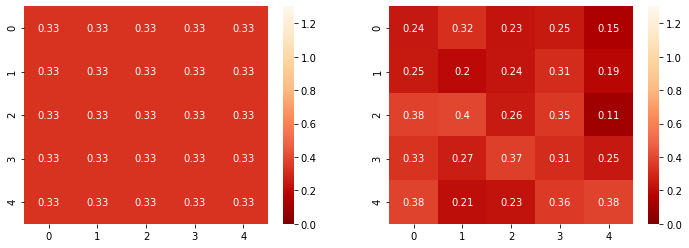

In [22]:
actual =  test['3'].to_numpy()
actual = np.reshape(actual,(actual.shape[0],1))
real=np.zeros((25,1))
predctd = np.zeros((25,1))

pos = int(input("Enter an integer between 0 to 6738 to test the model : "))
pos = pos*25+9

real=actual[pos:pos+25,-1]
predctd = predicted[pos:pos+25,-1]

real=np.reshape(real,(5,5))
predctd = np.reshape(predctd,(5,5))


print("Heatmap Actual and Heatmap predicted")
plt.figure(figsize=(12,4))
plt.subplot(121)
heat_map = sb.heatmap(real, vmin = 0, vmax = 1.30141, cmap="OrRd_r", annot=True)
plt.subplot(122)
heat_map = sb.heatmap(predctd,  vmin = 0, vmax = 1.30141, cmap="OrRd_r", annot=True)